In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Image preprocessing (128x128)

In [2]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm

In [6]:
IMG_HEIGHT = 137
IMG_WIDTH = 236
SIZE = 128
DATA_PATH = Path('../input')

In [4]:
!ls {DATA_PATH}

class_map.csv		   test_image_data_3.parquet
image_pickles		   train.csv
sample_submission.csv	   train_folds.csv
test.csv		   train_image_data_0.parquet
test_image_data_0.parquet  train_image_data_1.parquet
test_image_data_1.parquet  train_image_data_2.parquet
test_image_data_2.parquet  train_image_data_3.parquet


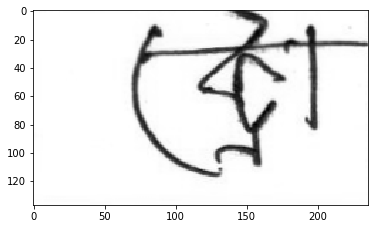

In [14]:
image = joblib.load(PATH/'image_pickles/Train_0.pkl')
image = image.reshape(HEIGHT, WIDTH)
plt.imshow(image, cmap='gray')

In [5]:
df = pd.read_parquet(DATA_PATH / 'train_image_data_0.parquet'); df.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_0,254,253,252,253,251,252,253,251,251,...,253,253,253,253,253,253,253,253,253,251
1,Train_1,251,244,238,245,248,246,246,247,251,...,255,255,255,255,255,255,255,255,255,254
2,Train_2,251,250,249,250,249,245,247,252,252,...,254,253,252,252,253,253,253,253,251,249
3,Train_3,247,247,249,253,253,252,251,251,250,...,254,254,254,254,254,253,253,252,251,252
4,Train_4,249,248,246,246,248,244,242,242,229,...,255,255,255,255,255,255,255,255,255,255


In [7]:
image = df.iloc[0, 1:].values.astype(np.uint8)
image = image.reshape(IMG_HEIGHT, IMG_WIDTH)
image

array([[254, 253, 252, ..., 254, 253, 251],
       [255, 253, 253, ..., 254, 253, 252],
       [255, 255, 255, ..., 254, 254, 253],
       ...,
       [254, 254, 253, ..., 253, 254, 252],
       [254, 254, 254, ..., 253, 253, 252],
       [254, 254, 254, ..., 253, 253, 251]], dtype=uint8)

In [8]:
mask = image[5:-5, 5:-5] < 80
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)

In [16]:
np.where(rows)[0][[0, -1]]

array([  0, 110])

In [17]:
np.where(cols)[0][[0, -1]]

array([ 66, 223])

In [20]:
image_crop = image[0:110, 66:223]

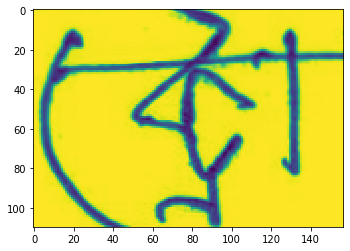

In [21]:
plt.imshow(image_crop)

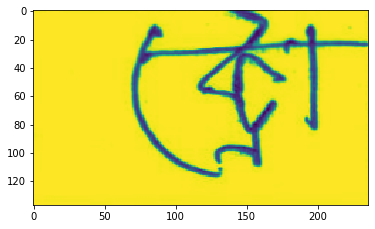

In [22]:
plt.imshow(image)